In [1]:
pip install openseespy opsvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 9.9 MB/s eta 0:00:00


In [2]:
import openseespy.opensees as ops
import opsvis as opsv
import os
import matplotlib.pyplot as plt

In [3]:
ops.wipe()
DataDir = r'Output'
if not os.path.exists(DataDir):
  os.makedirs(DataDir)

In [4]:
# Creating 2D Model
ops.model('Basic', '-ndm', 2, '-ndf', 3)

# Defining problem
numBay = 1
numFloor = 9

baywidth = 30.0 #(in ft)
storyheights = [0.0, 18.0, 32.0, 46.0, 60.0, 74.0, 88.0, 102.0, 116.0, 130.0] #(in ft)
#H2 = 14.0 #storey-height - vertical truss element
l = 5.5 #horizontal truss element length
Lc = 8 #Chord member length
h = 4.0 #vertical member height

#Material properties(steel)
E = 29007.6 #ksi(200 X 145.038)
lm = 3571.02 #lumped mass(in kips): single story mass X 9
Fy = 50.0 #ksi(assumed)

F = 10.0

# Section properties
#Columns
#(W30X292 section) - 1st floor
#(W30X261 section) - 2nd floor
#(W30X235 section) - 3rd floor
#(W30X211 section) - 4th floor
#(W30X191 section) - 5th floor
#(W30X148 section) - 6th floor
#(W30X132 section) - 7th floor
#(W30X108 section) - 8th floor
#(W24X84 section) - 9th floor
Acol = [86.0, 77.0, 69.3, 62.3, 56.1, 43.6, 38.8, 31.7, 24.7]
Icol = [14900, 13100, 11700, 10300, 9200, 6680, 5770, 4470, 2370]

#For chord-2 (C10 X 30 x 1.5 in plate)
A0 = 31.495
I2 = 132.18

#For vertical-1 (MC6X16.3)
A1 = 9.58
Iv = 52.0

#For diagonals (MC10X25)
A2 = 14.68
Id = 117.25

#For chord-1(truss), vertical-SS(truss), and chord-SS(I-Section) {C10 X 30}
A = 17.62
I1 = 34.52 #(About minor axis for chords)
Ivs = 206.0 #(About major axis for the vertical member)

# Defining Transformation for beam-column elements
ops.geomTransf('PDelta', 1)

# Add nodes
coords = []

for i in range(numFloor+1):
  y = storyheights[i]

  #Extreme Column-nodes:
  nodeTag_left = 10 + i     #10,11,12...
  nodeTag_right = 20 + i    #20,21,22...

  coords.append((nodeTag_left, 0.0, y))
  coords.append((nodeTag_right, baywidth, y))

  #Nodes in between
  if i > 0:
    #Mid-top chords
    coords += [
        (nodeTag_left*10 + 5, l, y),
        (nodeTag_left*10 + 6, 2*l, y),
        (nodeTag_left*10 + 7, 2*l+Lc, y),
        (nodeTag_left*10 + 8, baywidth - l, y),
    ]

    #Mid-bottom chords
    y_bot = y - h
    coords += [
        (nodeTag_left*10, 0.0, y_bot),
        (nodeTag_left*10 + 1, l, y_bot),
        (nodeTag_left*10 + 2, 2*l, y_bot),
        (nodeTag_left*10 + 3, 2*l+Lc, y_bot),
        (nodeTag_left*10 + 4, baywidth - l, y_bot),
        (nodeTag_right*10, baywidth, y_bot)
    ]

for tag, x, y in coords:
    ops.node(tag, x, y)

#Creating nodes for lean-on column:
ops.node(30, 2*baywidth, 0.0)
ops.node (39, 2*baywidth, storyheights[9])

# Fix base nodes with pins
ops.fix(10, 1, 1, 0)
ops.fix(20, 1, 1, 0)
ops.fix(30, 1, 1, 0)

#Defining material
ops.uniaxialMaterial('Elastic', 1, E)

#Element generation
eletag = 1
nodeL = 10
nodeR = 20
for i in range(numFloor+1):
  if i!=9:
    #Main columns
    ops.element('elasticBeamColumn', eletag, nodeL+i, (nodeL+i+1)*10, Acol[i], E, Icol[i], 1)
    eletag += 1
    ops.element('elasticBeamColumn', eletag, nodeR+i, (nodeR+i+1)*10, Acol[i], E, Icol[i], 1)
    eletag += 1
    ops.element('elasticBeamColumn', eletag, (nodeL+i+1)*10, nodeL+i+1,  Acol[i], E, Icol[i], 1)
    eletag += 1
    ops.element('elasticBeamColumn', eletag, (nodeR+i+1)*10, nodeR+i+1, Acol[i], E, Icol[i], 1)
    eletag += 1

  #Mid-elements
  if i > 0:
    #Chord-2
    ops.element('elasticBeamColumn', eletag, (nodeL+i), (nodeL+i)*10+5, A0, E, I2, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeR+i), (nodeL+i)*10+8, A0, E, I2, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10, (nodeL+i)*10+1, A0, E, I2, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeR+i)*10, (nodeL+i)*10+4, A0, E, I2, 1)
    eletag+=1

    #Chord-1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+5, (nodeL+i)*10+6, A, E, I1, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+7, (nodeL+i)*10+8, A, E, I1, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+1, (nodeL+i)*10+2, A, E, I1, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+3, (nodeL+i)*10+4, A, E, I1, 1)
    eletag+=1

    #vertical-1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+1, (nodeL+i)*10+5, A1, E, Iv, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+4, (nodeL+i)*10+8, A1, E, Iv, 1)
    eletag+=1

    #vertical-SS
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+2, (nodeL+i)*10+6, A, E, Ivs, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+3, (nodeL+i)*10+7, A, E, Ivs, 1)
    eletag+=1

    #diagonals
    ops.element('elasticBeamColumn', eletag, (nodeL+i), (nodeL+i)*10+1, A2, E, Id, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+1, (nodeL+i)*10+6, A2, E, Id, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+7, (nodeL+i)*10+4, A2, E, Id, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeR+i), (nodeL+i)*10+4, A2, E, Id, 1)
    eletag+=1

    #Chord-SS
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+6, (nodeL+i)*10+7, A, E, I1, 1)
    eletag+=1
    ops.element('elasticBeamColumn', eletag, (nodeL+i)*10+2, (nodeL+i)*10+3, A, E, I1, 1)
    eletag+=1

#adding Lean on column and a beam to support
ops.element('elasticBeamColumn', eletag, 30, 39, Acol[0], E, Icol[0], 1)
eletag+=1
ops.element('elasticBeamColumn', eletag, 29, 39, 10*A1, E, 10*I1, 1)
ops.mass(39, lm, 0.0)
ops.equalDOF(29, 39, 1, 2)

#Loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(19, 0.0, -F*100 , 0.0)


In [5]:
ops.recorder("Node", "-file", f"{DataDir}/Displacement.out", "-time","-closeOnWrite",
             "-node", 29, "-dof", 1, 2, "disp")
ops.recorder("Node", "-file", f"{DataDir}/RBase.out", "-time", "-closeOnWrite",
             "-node", 29, "-dof", 1, 2, "reaction")

1

In [6]:
# Analysis
ops.constraints("Plain")
ops.numberer("Plain")
ops.system("BandSPD")
ops.algorithm("Linear")
ops.integrator("LoadControl", 1)
ops.analysis("Static")

# Perform static analysis:
ops.analyze(1)

0

<Axes: >

<Figure size 2500x1000 with 0 Axes>

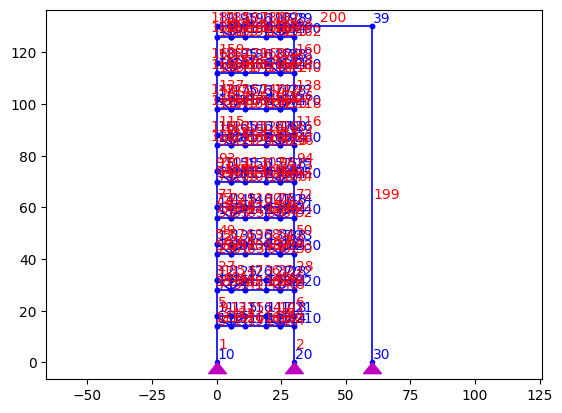

In [7]:
fig = plt.figure(figsize=(25, 10))
opsv.plot_model()

<Axes: >

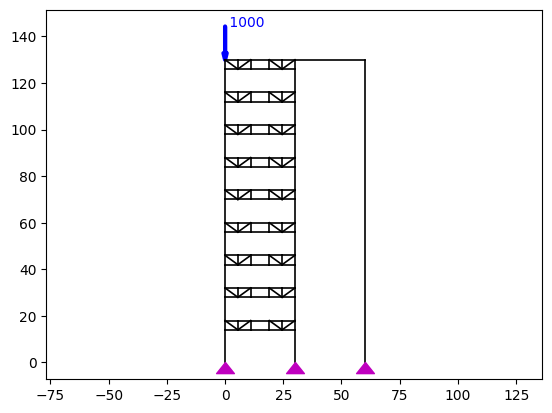

In [8]:
opsv.plot_load()


In [9]:
print(ops.nodeDOFs(10))

[-1, -1, 0]
